<a href="https://colab.research.google.com/github/samiha-mahin/Ovarian-cancer/blob/main/Multimodal_EfficientNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samihamuntahamahin","key":"1ad5aaba9143fbd38da418ad8d278398"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets list -s "ovarian cancer"

ref                                                             title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
saurabhshahane/predict-ovarian-cancer                           Predict Ovarian Cancer                                   322564  2021-02-06 08:15:47.360000           2920         47  0.7058824        
yoshifumimiya/6-ovarian-cancer-datasets                         7 ovarian cancer datasets                             239456735  2024-04-21 13:37:49.933000           3571         49  0.7647059        
sunilthite/ovarian-cancer-classification-dataset                Ovarian Cancer Subtype Classification                3554471607  2023-10-31 08:34:17.390000           1652         39  1.0          

In [10]:
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip

Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [12]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Define dataset path
DATASET_PATH = "OvarianCancer"

# Cancer classes (based on folder names)
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {class_name: i for i, class_name in enumerate(classes)}

# Image size for EfficientNetV2
IMG_SIZE = 224

# Lists to store images & labels
X, y = [], []

# Load images dynamically
for class_name in classes:
    class_path = os.path.join(DATASET_PATH, class_name)

    if not os.path.exists(class_path):
        continue  # Skip if folder doesn't exist

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip unreadable images

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = preprocess_input(img)  # EfficientNetV2 preprocessing
        X.append(img)
        y.append(class_mapping[class_name])  # Assign label

# Convert to NumPy arrays
X = np.array(X)
y = to_categorical(y, num_classes=len(classes))  # One-hot encode labels

# Split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset loaded: {len(X)} images")

Dataset loaded: 497 images


In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load CSV
csv_path = "Ovarian_patient_data.csv"
df = pd.read_csv(csv_path)

# Clean columns
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

# Feature columns to use
feature_cols = ['age', 'ca125', 'cancerstage', 'bmi']
df = df.dropna(subset=feature_cols)
df = df.reset_index(drop=True)

# Ensure we have enough rows to match images
df = df.iloc[:497]

# Normalize
scaler = StandardScaler()
X_tabular = scaler.fit_transform(df[feature_cols].values)


In [15]:
X_tab_train, X_tab_test = train_test_split(X_tabular, test_size=0.2, random_state=42)


In [16]:
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import EfficientNetV2B0

# Image model (EfficientNetV2B0)
image_input = Input(shape=(224, 224, 3))
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_tensor=image_input, pooling='avg')
x = layers.Dense(128, activation='relu')(base_model.output)
x = layers.Dropout(0.3)(x)

# Tabular model
tab_input = Input(shape=(X_tabular.shape[1],))
y = layers.Dense(64, activation='relu')(tab_input)
y = layers.Dense(32, activation='relu')(y)

# Merge
combined = layers.concatenate([x, y])
z = layers.Dense(64, activation='relu')(combined)
z = layers.Dense(len(classes), activation='softmax')(z)

model = Model(inputs=[image_input, tab_input], outputs=z)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
model.fit(
    [X_train, X_tab_train],
    y_train,
    validation_data=([X_test, X_tab_test], y_test),
    epochs=10,
    batch_size=16
)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 214s 5s/step - accuracy: 0.4228 - loss: 1.3722 - val_accuracy: 0.7900 - val_loss: 0.7304
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step - accuracy: 0.8252 - loss: 0.5588 - val_accuracy: 0.7700 - val_loss: 0.7490
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.8476 - loss: 0.4316 - val_accuracy: 0.7400 - val_loss: 0.9683
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 136s 5s/step - accuracy: 0.9248 - loss: 0.3036 - val_accuracy: 0.7900 - val_loss: 0.8088
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.9224 - loss: 0.2877 - val_accuracy: 0.7200 - val_loss: 0.8691
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.9315 - loss: 0.2329 - val_accuracy: 0.8200 - val_loss: 0.4749
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 149s 5s/step - accuracy: 0.9379 - loss: 0.2297 - val_accuracy: 0.8000 - val_loss: 0.7384
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.9422 - loss: 0.1635 - val_accuracy: 0.8000 - v

In [18]:
loss, acc = model.evaluate([X_test, X_tab_test], y_test)
print(f"\n✅ Multimodal Accuracy: {acc * 100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6750 - loss: 1.3394

✅ Multimodal Accuracy: 69.00%


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3716 - loss: 1.4767
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 215s 5s/step - accuracy: 0.3768 - loss: 1.4685 - val_accuracy: 0.7500 - val_loss: 0.8436
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7722 - loss: 0.7034
Epoch 2: val_accuracy did not improve from 0.75000
25/25 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.7731 - loss: 0.7005 - val_accuracy: 0.7400 - val_loss: 0.8680
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8902 - loss: 0.4029
Epoch 3: val_accuracy improved from 0.75000 to 0.78000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - accuracy: 0.8890 - loss: 0.4055 - val_accuracy: 0.7800 - val_loss: 0.7369
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8831 - loss: 0.3439
Epoch 4: val_accuracy did not improve from 0.78000
25/25 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - accuracy: 0.8837 - loss: 0.3434 - val_accuracy: 0.7500 - val_loss: 0.7587
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8971 - loss: 0.2852
Epoch 5: val_accuracy improved from 0.78000 to 0.79000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.8976 - loss: 0.2849 - val_accuracy: 0.7900 - val_loss: 0.7137
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9137 - loss: 0.2836
Epoch 6: val_accuracy did not improve from 0.79000
25/25 ━━━━━━━━━━━━━━━━━━━━ 121s 5s/step - accuracy: 0.9130 - loss: 0.2852 - val_accuracy: 0.7000 - val_loss: 1.0280
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9328 - loss: 0.2466
Epoch 7: val_accuracy improved from 0.79000 to 0.80000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.9327 - loss: 0.2459 - val_accuracy: 0.8000 - val_loss: 0.6902
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9435 - loss: 0.2001
Epoch 8: val_accuracy did not improve from 0.80000
25/25 ━━━━━━━━━━━━━━━━━━━━ 124s 5s/step - accuracy: 0.9431 - loss: 0.2002 - val_accuracy: 0.7700 - val_loss: 0.8502
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9050 - loss: 0.2911
Epoch 9: val_accuracy did not improve from 0.80000
25/25 ━━━━━━━━━━━━━━━━━━━━ 116s 5s/step - accuracy: 0.9057 - loss: 0.2905 - val_accuracy: 0.7600 - val_loss: 0.8021
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9269 - loss: 0.2096
Epoch 10: val_accuracy did not improve from 0.80000
25/25 ━━━━━━━━━━━━━━━━━━━━ 149s 5s/step - accuracy: 0.9271 - loss: 0.2084 - val_accuracy: 0.7600 - val_loss: 1.0759
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8023 - loss: 0.6705

✅ Best Multimodal Accuracy: 80.00%


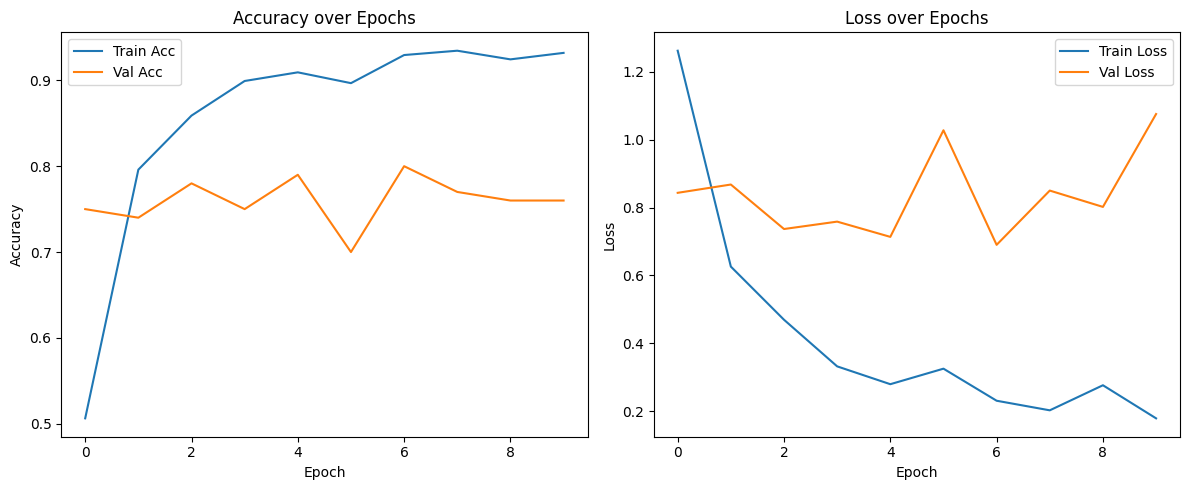

In [35]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint

# -----------------------------
# Load and preprocess image data
# -----------------------------
IMG_SIZE = 224
DATASET_PATH = "OvarianCancer"
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {name: i for i, name in enumerate(classes)}

X_images, y_labels = [], []

for class_name in classes:
    folder = os.path.join(DATASET_PATH, class_name)
    if not os.path.exists(folder): continue
    for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = preprocess_input(img)
        X_images.append(img)
        y_labels.append(class_mapping[class_name])

X_images = np.array(X_images)
y_labels = to_categorical(y_labels, num_classes=len(classes))

# -----------------------------
# Load and preprocess tabular data
# -----------------------------
df = pd.read_csv("Ovarian_patient_data.csv")
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()
features = ['age', 'ca125', 'cancerstage', 'bmi']
df = df.dropna(subset=features).reset_index(drop=True)
df = df.iloc[:len(X_images)]  # Ensure alignment

scaler = StandardScaler()
X_tabular = scaler.fit_transform(df[features].values)

# -----------------------------
# Train-test split
# -----------------------------
X_train_img, X_test_img, X_train_tab, X_test_tab, y_train, y_test = train_test_split(
    X_images, X_tabular, y_labels, test_size=0.2, random_state=42
)

# -----------------------------
# Build multimodal model
# -----------------------------
image_input = Input(shape=(224, 224, 3), name="image_input")
base_model = EfficientNetV2B0(include_top=False, weights="imagenet", input_tensor=image_input, pooling="avg")
x = layers.Dense(128, activation="relu")(base_model.output)
x = layers.Dropout(0.3)(x)

tabular_input = Input(shape=(X_tabular.shape[1],), name="tabular_input")
y = layers.Dense(64, activation="relu")(tabular_input)
y = layers.Dense(32, activation="relu")(y)

combined = layers.concatenate([x, y])
z = layers.Dense(64, activation="relu")(combined)
output = layers.Dense(len(classes), activation="softmax")(z)

model = Model(inputs=[image_input, tabular_input], outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# -----------------------------
# Callbacks
# -----------------------------
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)

# -----------------------------
# Train
# -----------------------------
history = model.fit(
    [X_train_img, X_train_tab],
    y_train,
    validation_data=([X_test_img, X_test_tab], y_test),
    epochs=10,
    batch_size=16,
    callbacks=[checkpoint]
)

# -----------------------------
# Load best model and evaluate
# -----------------------------
model.load_weights("best_model.h5")
loss, acc = model.evaluate([X_test_img, X_test_tab], y_test)
print(f"\n✅ Best Multimodal Accuracy: {acc * 100:.2f}%")

# -----------------------------
# Plot accuracy and loss
# -----------------------------
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
